Given an image of 32*32*3 which is 3072 we want to classify it to one of the 10 classes

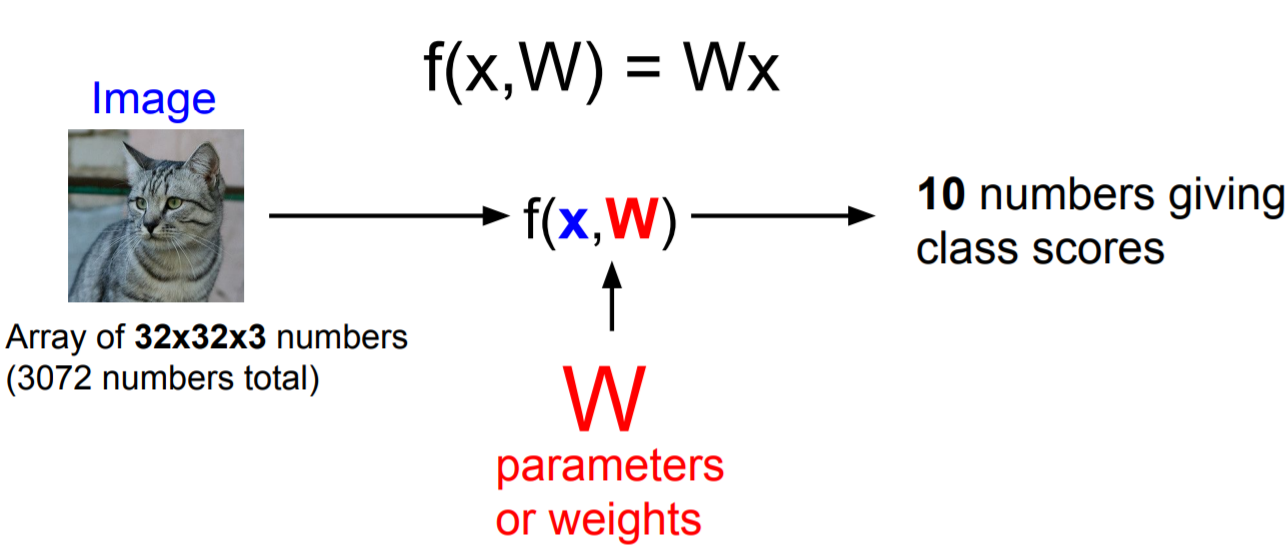

Thus If we do x as 3047*1 and W as 10*3047, then f(x,W) would be 10*1

### Example with an image with 4 pixels and 3 classes, dog cat or ship

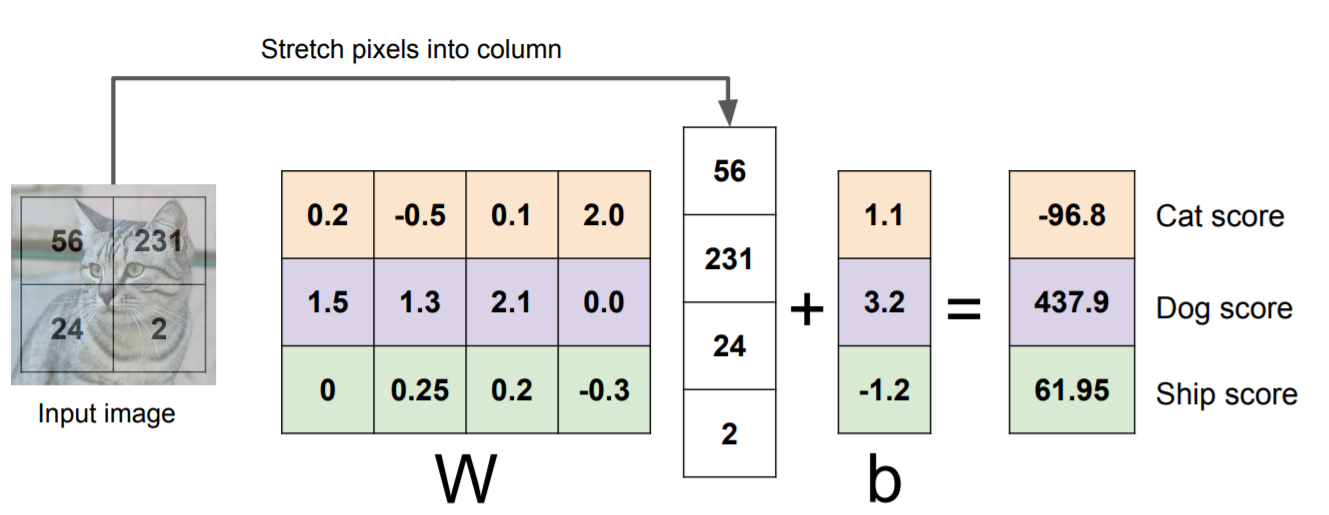

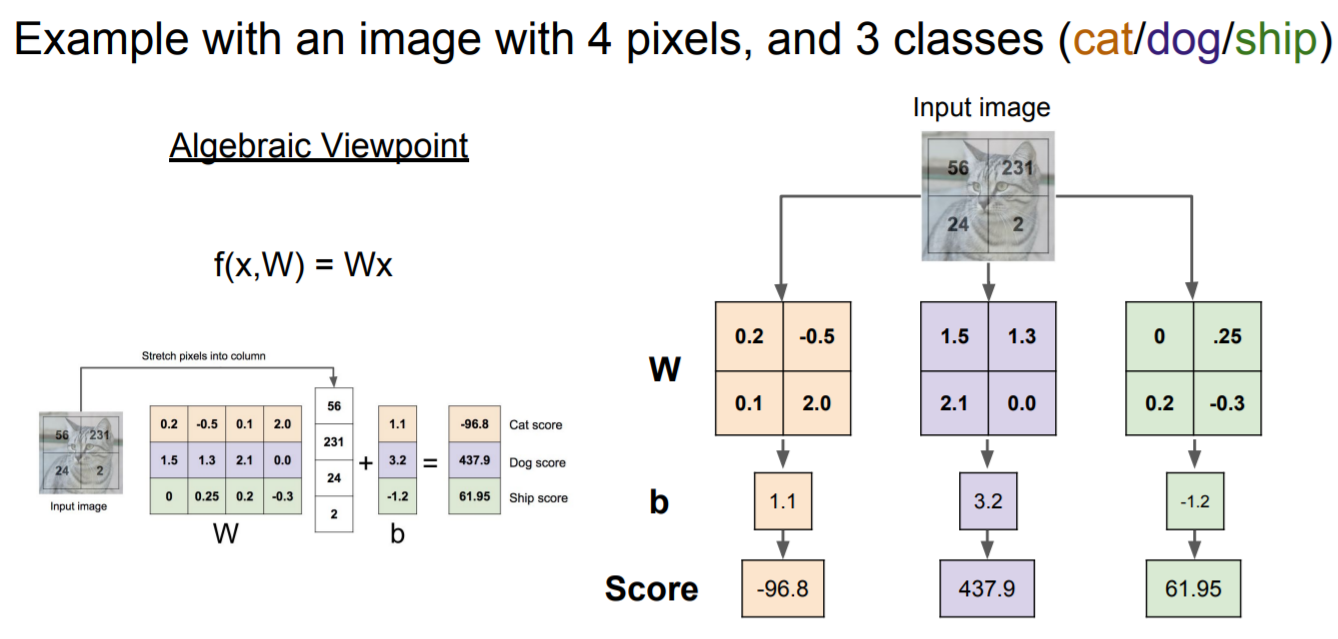

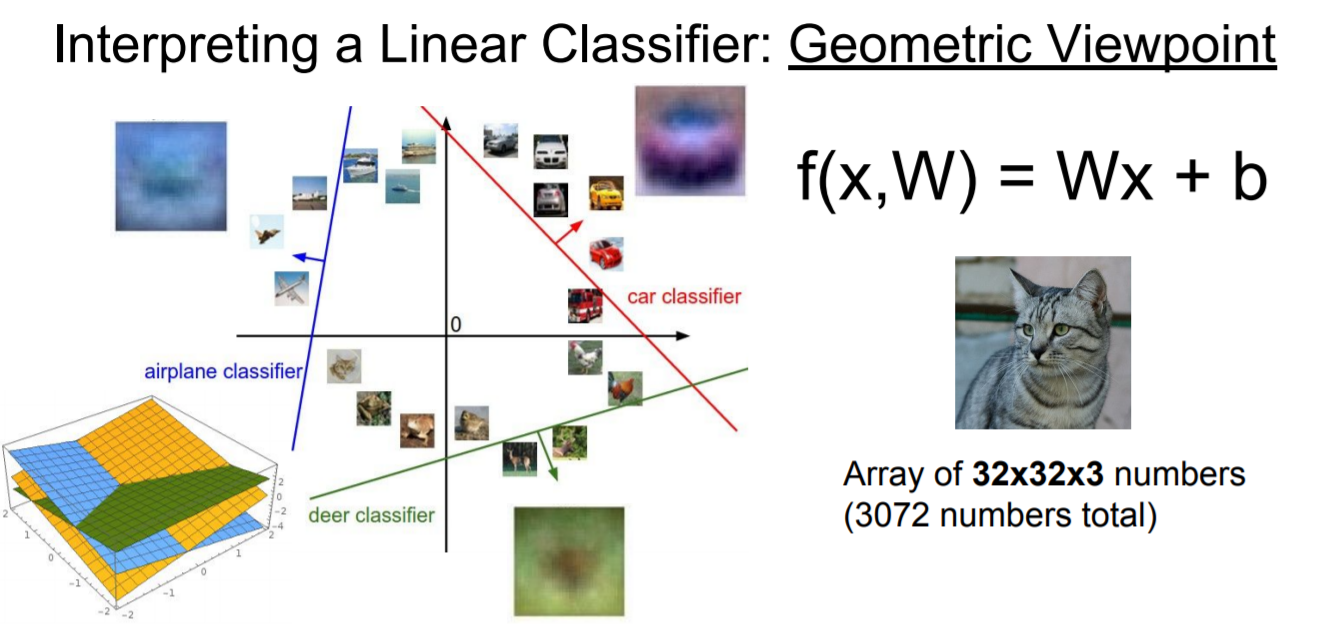

Well in many cases Linear classifier can't help us like

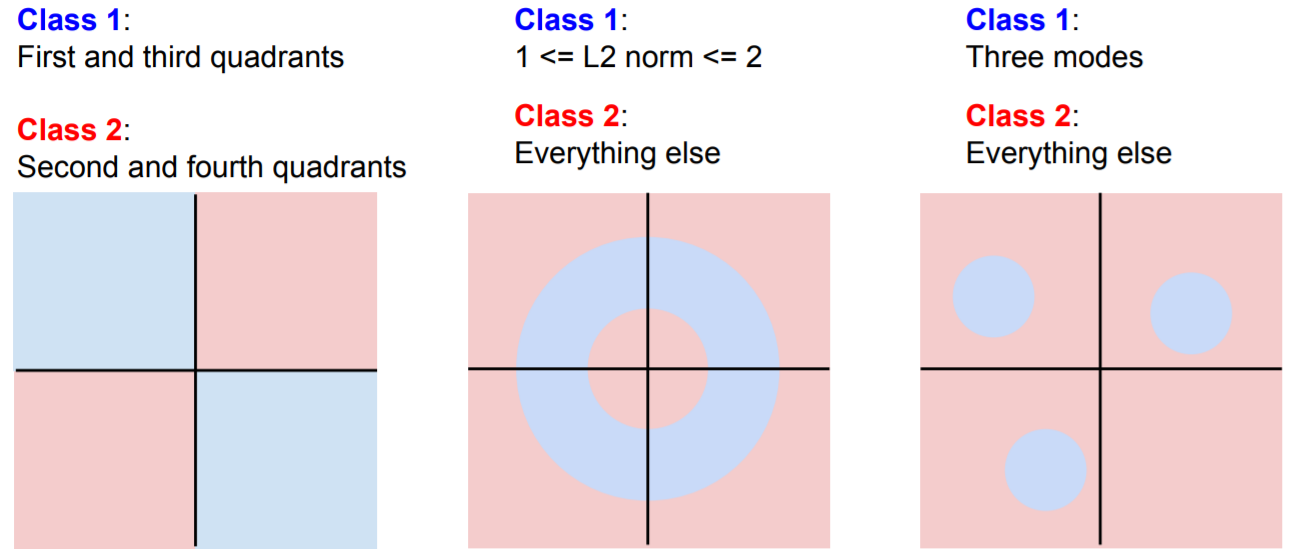

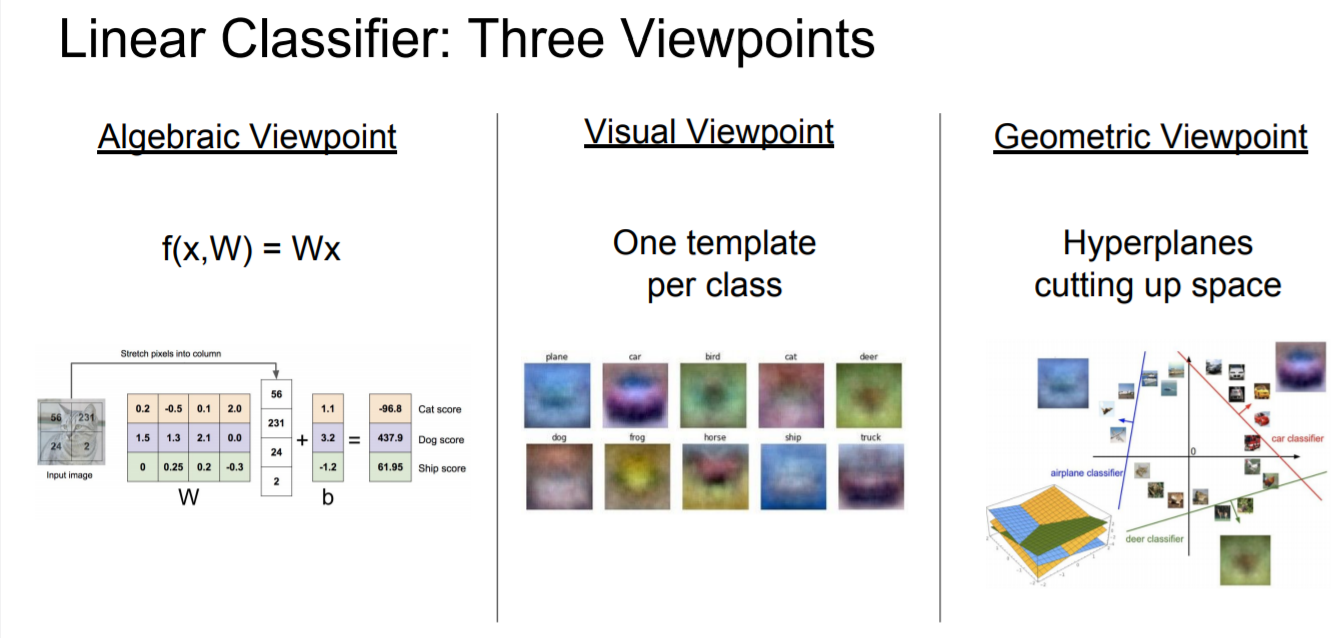

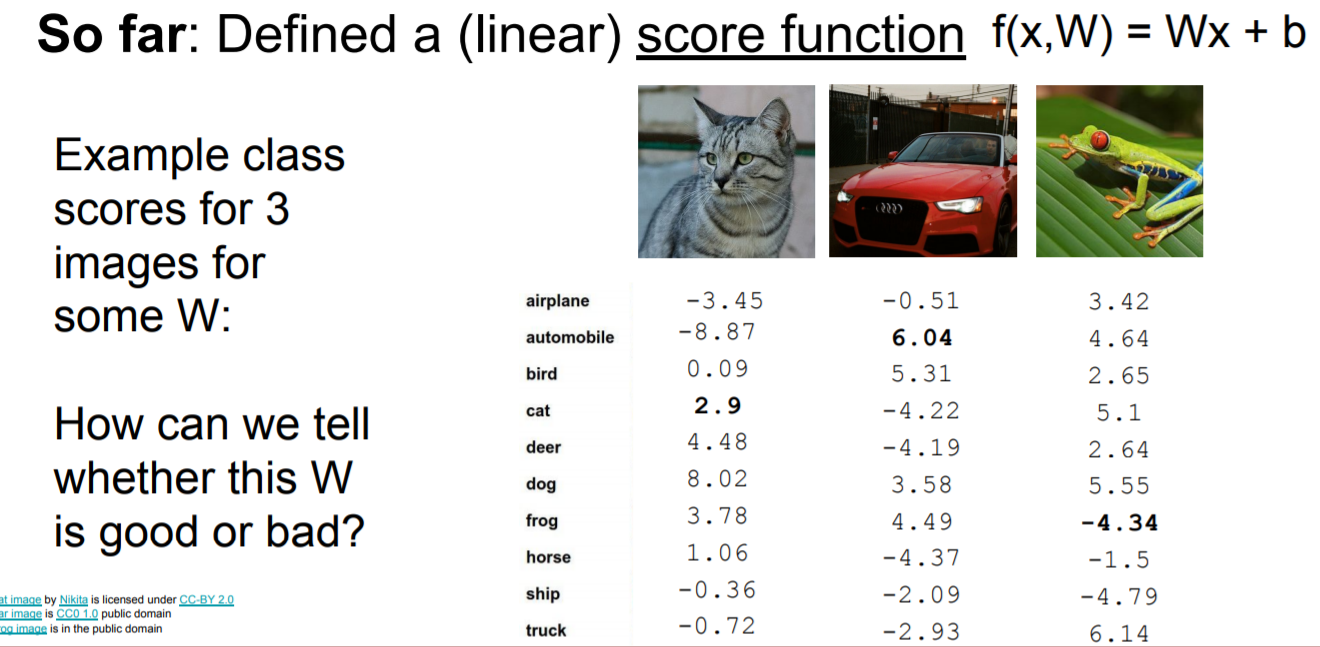


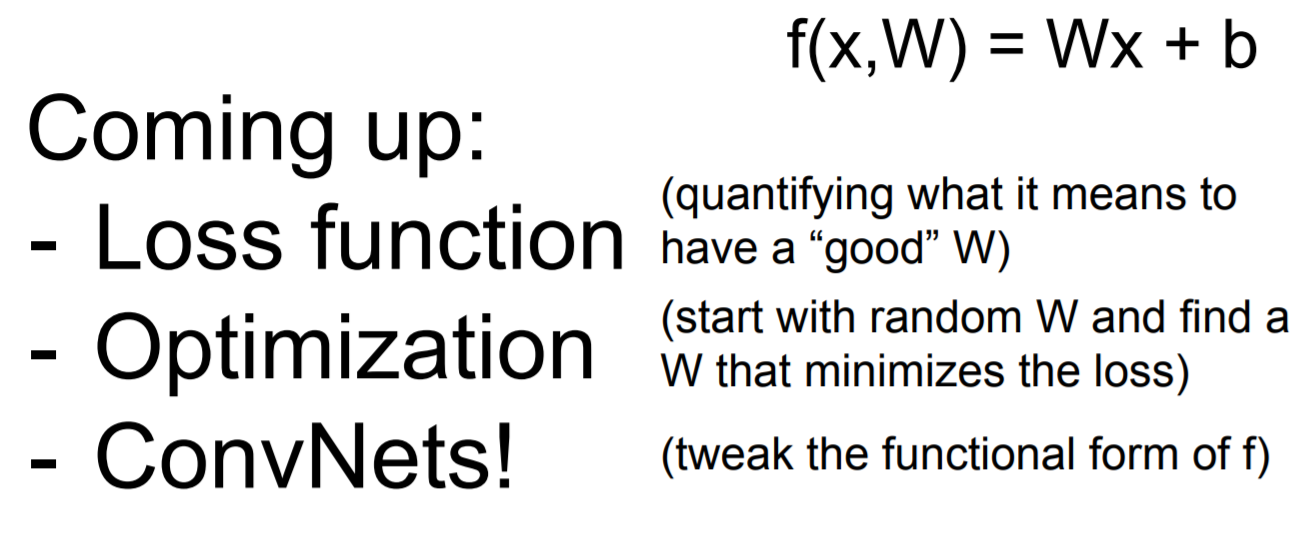

In [2]:
def L_i(x, y, W):
  """
  unvectorized version. Compute the multiclass svm loss for a single example (x,y)
  - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
    with an appended bias dimension in the 3073-rd position (i.e. bias trick)
  - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
  - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
  """
  delta = 1.0 # see notes about delta later in this section
  scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
  correct_class_score = scores[y]
  D = W.shape[0] # number of classes, e.g. 10
  loss_i = 0.0
  for j in xrange(D): # iterate over all wrong classes
    if j == y:
      # skip for the true class to only loop over incorrect classes
      continue
    # accumulate loss for the i-th example
    loss_i += max(0, scores[j] - correct_class_score + delta)
  return loss_i



In [1]:
def L_i_vectorized(x, y, W):
  """
  A faster half-vectorized implementation. half-vectorized
  refers to the fact that for a single example the implementation contains
  no for loops, but there is still one loop over the examples (outside this function)
  """
  delta = 1.0
  scores = W.dot(x)
  # compute the margins for all classes in one vector operation
  margins = np.maximum(0, scores - scores[y] + delta)
  # on y-th position scores[y] - scores[y] canceled and gave delta. We want
  # to ignore the y-th position and only consider margin on max wrong class
  margins[y] = 0
  loss_i = np.sum(margins)
  return loss_i


In [11]:
def L(X, y, W):
    """
    fully-vectorized implementation :
    - X holds all the training examples as columns (e.g. 3073 x 50,000 in CIFAR-10)
    - y is array of integers specifying correct class (e.g. 50,000-D array)
    - W are weights (e.g. 10 x 3073)
    """
    # evaluate loss over all examples in X without using any for loops
    # left as exercise to reader in the assignment
    delta=1.0
    scores=W.dot(x)

    # doing with for loop, see how it can be done without loops
    loss=0
    for label,i in zip(y,range(x.shape[1])):
        margins=np.maximum(0,scores[:][i]-label+delta)
        margins[labels]=0
        loss+=np.sum(margins)
    return loss

Good practise to avoid division of big numbers

In [12]:
import numpy as np

In [13]:
f = np.array([123, 456, 789]) # example with 3 classes and each having large scores
p = np.exp(f) / np.sum(np.exp(f)) # Bad: Numeric problem, potential blowup

# instead: first shift the values of f so that the highest number is 0:
f -= np.max(f) # f becomes [-666, -333, 0]
p = np.exp(f) / np.sum(np.exp(f)) # safe to do, gives the correct answer


C:\Users\saurabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


### Optimization

Randomly searching the best weights

In [16]:
bestloss = float("inf") # Python assigns the highest possible float value
for num in range(1000):
  W = np.random.randn(10, 3073) * 0.0001 # generate random parameters
  loss = L(X_train, Y_train, W) # get the loss over the entire training set
  if loss < bestloss: # keep track of the best solution
    bestloss = loss
    bestW = W
  print ('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

NameError: name 'X_train' is not defined

We can take this best random parameter and see the results

In [ ]:
# Assume X_test is [3073 x 10000], Y_test [10000 x 1]
scores = Wbest.dot(Xte_cols) # 10 x 10000, the class scores for all test examples
# find the index with max score in each column (the predicted class)
Yte_predict = np.argmax(scores, axis = 0)
# and calculate accuracy (fraction of predictions that are correct)
np.mean(Yte_predict == Yte)
# returns 0.1555

**Core idea: iterative refinement.**

Of course, it turns out that we can do much better. The core idea is that finding the best set of weights W is a very difficult or even impossible problem (especially once W contains weights for entire complex neural networks), but the problem of refining a specific set of weights W to be slightly better is significantly less difficult. In other words, our approach will be to start with a random W and then iteratively refine it, making it slightly better each time.

**Strategy #2: Random Local Search**

The first strategy you may think of is to try to extend one foot in a random direction and then take a step only if it leads downhill. Concretely, we will start out with a random W, generate random perturbations δW to it and if the loss at the perturbed W+δW is lower, we will perform an update. The code for this procedure is as follows:

In [ ]:
W = np.random.randn(10, 3073) * 0.001 # generate random starting W
bestloss = float("inf")
for i in xrange(1000):
  step_size = 0.0001
  Wtry = W + np.random.randn(10, 3073) * step_size
  loss = L(Xtr_cols, Ytr, Wtry)
  if loss < bestloss:
    W = Wtry
    bestloss = loss
  print 'iter %d loss is %f' % (i, bestloss)

### What is The accuracy ? on test set as done above

Using the same number of loss function evaluations as before (1000), this approach achieves test set classification accuracy of 21.4%. This is better, but still wasteful and computationally expensive.

**Strategy #3: Following the Gradient**

In the previous section we tried to find a direction in the weight-space that would improve our weight vector (and give us a lower loss). It turns out that there is no need to randomly search for a good direction: we can compute the best direction along which we should change our weight vector that is mathematically guaranteed to be the direction of the steepest descend (at least in the limit as the step size goes towards zero). This direction will be related to the gradient of the loss function. In our hiking analogy, this approach roughly corresponds to feeling the slope of the hill below our feet and stepping down the direction that feels steepest.

In one-dimensional functions, the slope is the instantaneous rate of change of the function at any point you might be interested in. The gradient is a generalization of slope for functions that don’t take a single number but a vector of numbers. Additionally, the gradient is just a vector of slopes (more commonly referred to as derivatives) for each dimension in the input space. The mathematical expression for the derivative of a 1-D function with respect its input is:

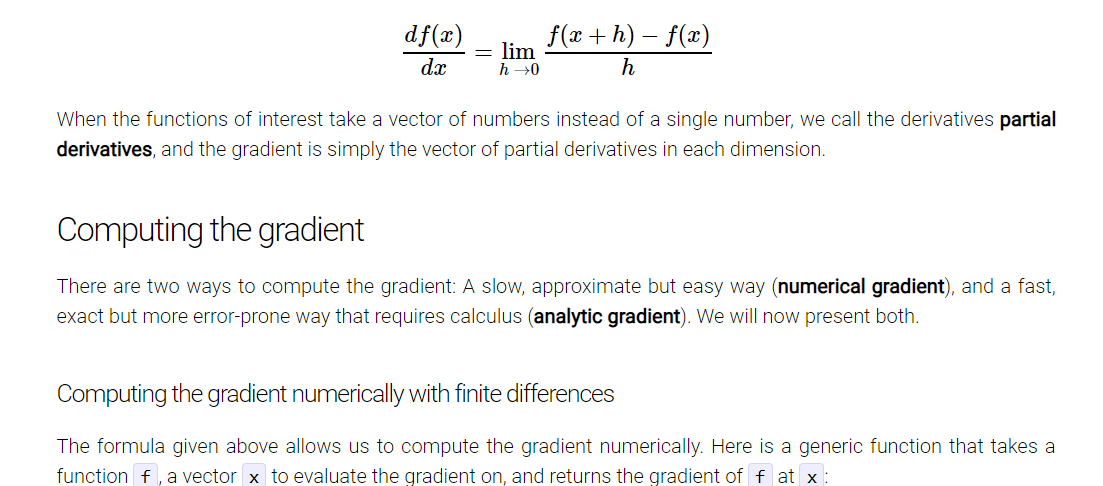

http://cs231n.stanford.edu/slides/2019/cs231n_2019_lecture03.pdf

See how the gradients are calculated, and this method of numerical grad calculation is very slow

**Beautiful implementation of calculating gradient**

In [17]:
def eval_numerical_gradient(f, x):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros(x.shape)
  h = 0.00001

  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    old_value = x[ix]
    x[ix] = old_value + h # increment by h
    fxh = f(x) # evalute f(x + h)
    x[ix] = old_value # restore to previous value (very important!)

    # compute the partial derivative
    grad[ix] = (fxh - fx) / h # the slope
    it.iternext() # step to next dimension

  return grad

**Practical considerations** Note that in the mathematical formulation the gradient is defined in the limit as h goes towards zero, but in practice it is often sufficient to use a very small value (such as 1e-5 as seen in the example). Ideally, you want to use the smallest step size that does not lead to numerical issues. Additionally, in practice it often works better to compute the numeric gradient using the centered difference formula

In [ ]:
# to use the generic code above we want a function that takes a single argument
# (the weights in our case) so we close over X_train and Y_train
def CIFAR10_loss_fun(W):
  return L(X_train, Y_train, W)

W = np.random.rand(10, 3073) * 0.001 # random weight vector
df = eval_numerical_gradient(CIFAR10_loss_fun, W) # get the gradient

The gradient tells us the slope of the loss function along every dimension, which we can use to make an update:

In [ ]:
loss_original = CIFAR10_loss_fun(W) # the original loss
print 'original loss: %f' % (loss_original, )

# lets see the effect of multiple step sizes
for step_size_log in [-10, -9, -8, -7, -6, -5,-4,-3,-2,-1]:
  step_size = 10 ** step_size_log
  W_new = W - step_size * df # new position in the weight space
  loss_new = CIFAR10_loss_fun(W_new)
  print 'for step size %f new loss: %f' % (step_size, loss_new)


At last we are having a high learning rate and thus loss is overshotting

**A problem of efficiency**

You may have noticed that evaluating the numerical gradient has complexity linear in the number of parameters. In our example we had 30730 parameters in total and therefore had to perform 30,731 evaluations of the loss function to evaluate the gradient and to perform only a single parameter update. This problem only gets worse, since modern Neural Networks can easily have tens of millions of parameters. Clearly, this strategy is not scalable and we need something better.

1 parameter takes 30730 operations and then 30730 would take 3*10^8 operations

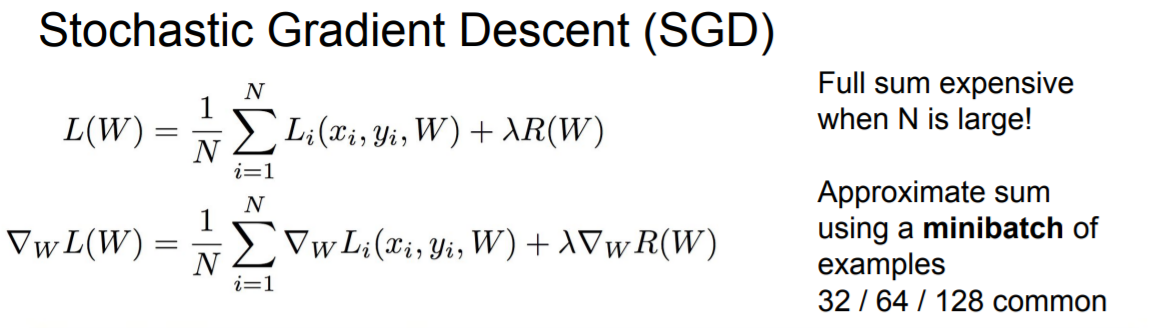

Refer to the pdf

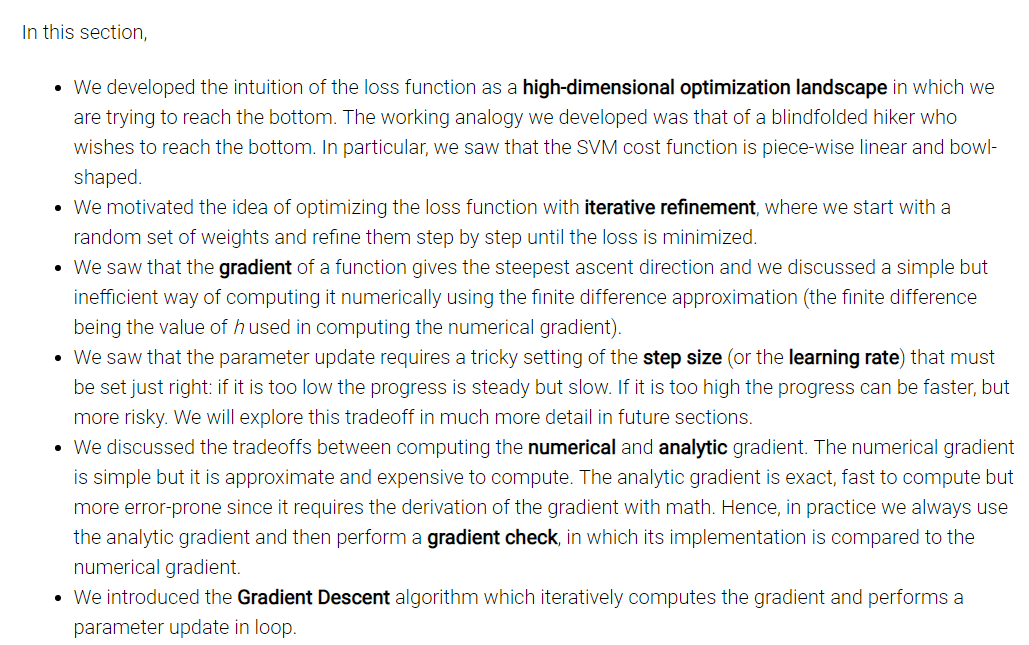